In [3]:
import os
import json
import numpy as np
import torch
import matplotlib.pyplot as plt

In [4]:
# Loading paths of models and configs

# Paths
models_subdir_path = "../../../finetuned_models/"
model_paths = {}
for model_subdir in os.listdir(models_subdir_path):
    subdir_models_path = models_subdir_path + model_subdir + "/"
    subdir_model_names = os.listdir(subdir_models_path)
    
    for subdir_model_name in subdir_model_names:
        model_paths[subdir_model_name] = subdir_models_path + subdir_model_name + "/"
      
# Configs
model_config_paths = {k: v.replace("finetuned_models", "pretrained_models").replace("adapted_", "") + "config.json" for k, v in model_paths.items()}
model_configs = {}
for model_name, model_config_path in model_config_paths.items():
    model_config = {}
    with open(model_config_path, "r") as f:
        model_all_configs = json.load(f)
    model_data_params = model_all_configs["data_params"]
    model_params = model_all_configs["model_params"]
    
    model_config["input_name"] = model_data_params["input_name"]
    model_config["interval_skip"] = model_data_params["interval_skip"]
    model_config["upper_range"] = model_data_params["upper_range"]
    model_config["noise_scalar"] = model_data_params["noise_scalar"]
    model_configs[model_name] = model_config
    
# Model names
baseline_names = []
deciwatch_names = []
adapted_names = []
lowlr_deciwatch_names = []
highlr_deciwatch_names = []
unipose_names = []
unipose2_names = []
name_mapping = {"baseline": baseline_names, "deciwatch": deciwatch_names, "adapted": adapted_names, "unipose": unipose_names, "unipose2": unipose2_names}

for model_name in model_paths.keys():
    model_type = model_name.split("_")[0]
    name_mapping[model_type].append(model_name)

In [5]:
# Extracting leaning rates

learning_rates = {}

for model_name, model_path in model_paths.items():
    num_epochs = len(np.load(model_path + "train_losses.npy"))
    model_learning_rates = {}
    
    for epoch in range(1, num_epochs + 1):
        epoch_scheduler = torch.load(model_path + str(epoch) + "/scheduler.pth", map_location="cpu")
        epoch_lr = None if not "_last_lr" in epoch_scheduler.state_dict() else epoch_scheduler.state_dict()["_last_lr"][0]
        
        if epoch_lr is not None and epoch_lr not in model_learning_rates.values() and epoch_lr < 9.999999999999999e-05:
            model_learning_rates[epoch] = epoch_lr
        
    learning_rates[model_name] = model_learning_rates

In [6]:
# Colors
colors = ["blue", "red", "green", "purple", "orange", "brown"]

# Function for getting label
def get_label(model_type, config):
    model_to_label = {"baseline": "3DConv", "deciwatch": "DeciWatch", "adapted": "DeciWatch", "unipose": "bi-ConvLSTM - Model S", "unipose2": "bi-ConvLSTM - Model C"}
    model_type = model_to_label[model_type]
    
    noise_scalar = config["noise_scalar"]
    interval_skip = config["interval_skip"]
    input_name = config["input_name"]
    
    if input_name == "input_std" and interval_skip == 0:
        setup = "1"
    elif input_name == "input":
        setup = "2"
    if input_name == "input_std" and interval_skip == 1:
        setup = "3"
        
    return f"{model_type} {noise_scalar}.{setup}"

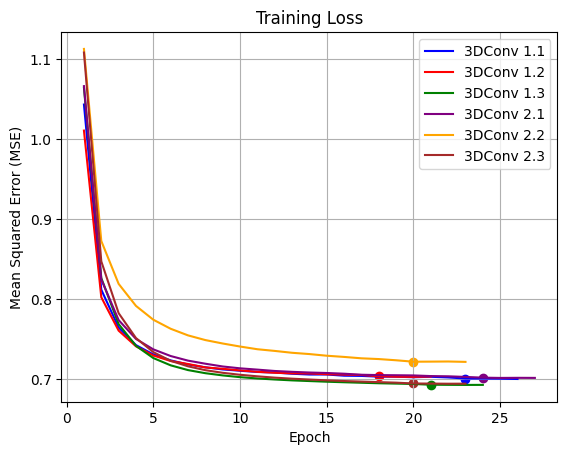

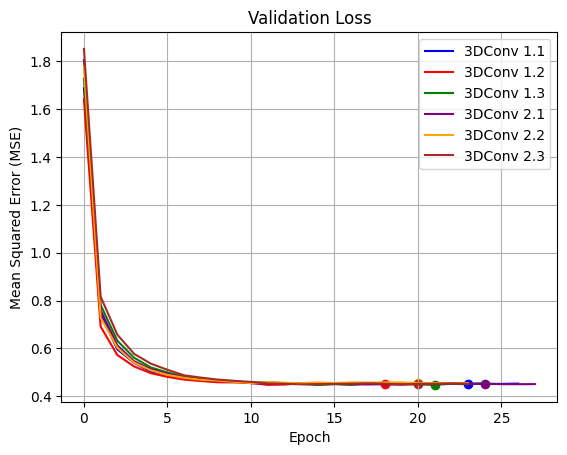

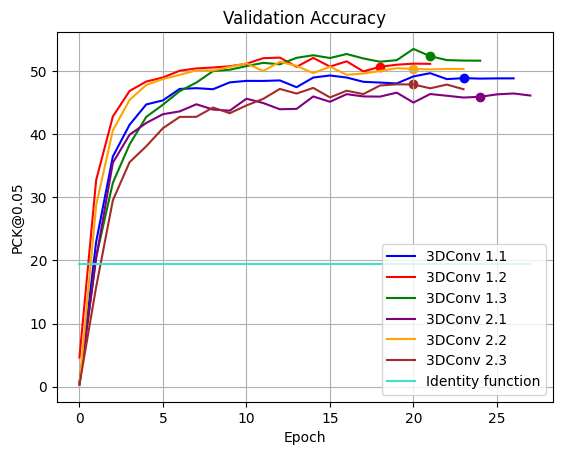

In [7]:
# Baseline plots

model_type = "baseline"
identity_1 = 19.4

plt.figure()
for color, name in zip(colors, baseline_names):
    path = model_paths[name]
    config = model_configs[name]
    learning_rate = learning_rates[name]
    label = get_label(model_type, config)

    train_losses = np.load(path + "train_losses.npy")
    xs = np.arange(1, len(train_losses) + 1)
    plt.plot(xs, train_losses, c=color, label=label)
    
    for epoch in learning_rate.keys():
        plt.scatter(epoch, train_losses[epoch - 1], c=color)
    
plt.grid()
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.savefig(f"./{model_type}/train_losses.png")

plt.figure()
for color, name in zip(colors, baseline_names):
    path = model_paths[name]
    config = model_configs[name]
    learning_rate = learning_rates[name]
    label = get_label(model_type, config)

    val_losses = np.load(path + "val_losses.npy")
    xs = np.arange(len(val_losses))
    plt.plot(xs, val_losses, c=color, label=label)
    
    for epoch in learning_rate.keys():
        plt.scatter(epoch, val_losses[epoch], c=color)
    
plt.grid()
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.savefig(f"./{model_type}/val_losses.png")

plt.figure()
max_len = 0
for color, name in zip(colors, baseline_names):
    path = model_paths[name]
    config = model_configs[name]
    learning_rate = learning_rates[name]
    label = get_label(model_type, config)

    val_accs = np.load(path + "val_accs.npy") * 100
    num_epochs = len(val_accs)
    max_len = max(max_len, num_epochs)
    xs = np.arange(num_epochs)
    plt.plot(xs, val_accs, c=color, label=label)
    
    for epoch in learning_rate.keys():
        plt.scatter(epoch, val_accs[epoch], c=color)
    
plt.plot(np.arange(max_len), np.full(max_len, identity_1), c="turquoise", label="Identity function")

plt.grid()
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("PCK@0.05")
plt.legend()
plt.savefig(f"./{model_type}/val_accs.png")

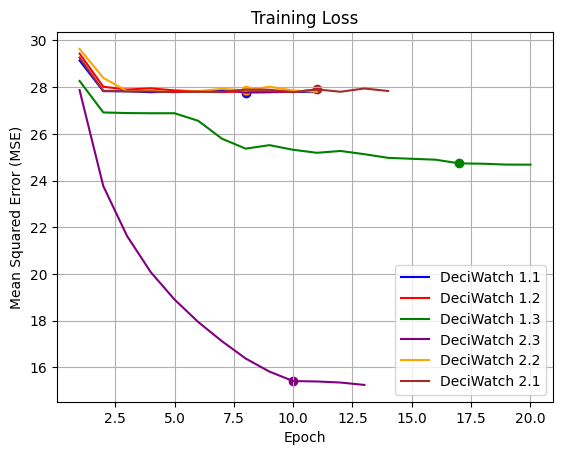

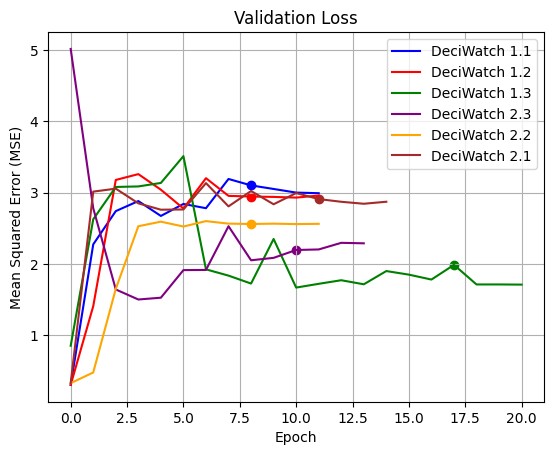

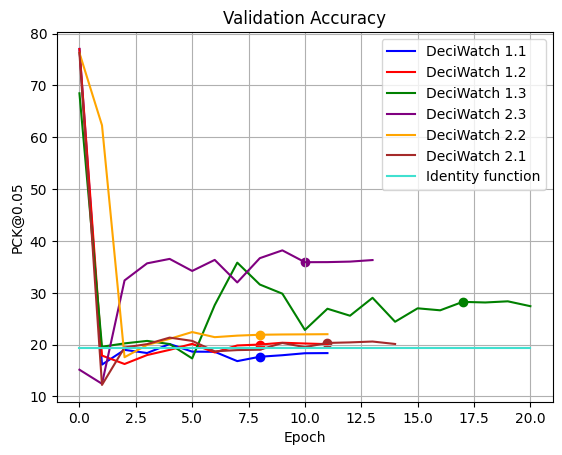

In [8]:
# Baseline plots

model_type = "deciwatch"
identity_1 = 19.4

plt.figure()
for color, name in zip(colors, deciwatch_names):
    path = model_paths[name]
    config = model_configs[name]
    learning_rate = learning_rates[name]
    label = get_label(model_type, config)

    train_losses = np.load(path + "train_losses.npy")
    xs = np.arange(1, len(train_losses) + 1)
    plt.plot(xs, train_losses, c=color, label=label)
    
    for epoch in learning_rate.keys():
        plt.scatter(epoch, train_losses[epoch - 1], c=color)
    
plt.grid()
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.savefig(f"./{model_type}/train_losses.png")

plt.figure()
for color, name in zip(colors, deciwatch_names):
    path = model_paths[name]
    config = model_configs[name]
    learning_rate = learning_rates[name]
    label = get_label(model_type, config)

    val_losses = np.load(path + "val_losses.npy")
    xs = np.arange(len(val_losses))
    plt.plot(xs, val_losses, c=color, label=label)
    
    for epoch in learning_rate.keys():
        plt.scatter(epoch, val_losses[epoch], c=color)
    
plt.grid()
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.savefig(f"./{model_type}/val_losses.png")

plt.figure()
max_len = 0
for color, name in zip(colors, deciwatch_names):
    path = model_paths[name]
    config = model_configs[name]
    learning_rate = learning_rates[name]
    label = get_label(model_type, config)

    val_accs = np.load(path + "val_accs.npy") * 100
    num_epochs = len(val_accs)
    max_len = max(max_len, num_epochs)
    xs = np.arange(num_epochs)
    plt.plot(xs, val_accs, c=color, label=label)
    
    for epoch in learning_rate.keys():
        plt.scatter(epoch, val_accs[epoch], c=color)
    
plt.plot(np.arange(max_len), np.full(max_len, identity_1), c="turquoise", label="Identity function")

plt.grid()
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("PCK@0.05")
plt.legend(loc="upper right")
plt.savefig(f"./{model_type}/val_accs.png")

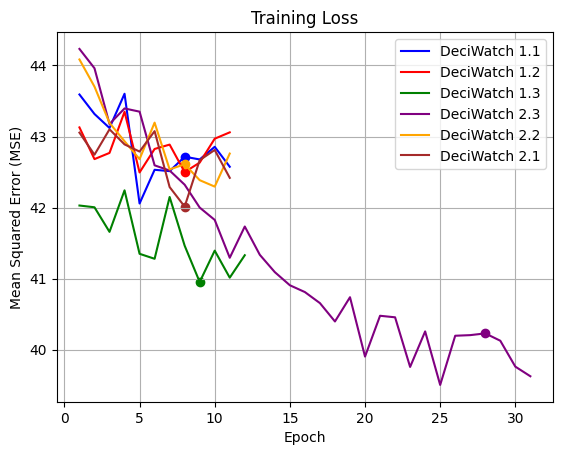

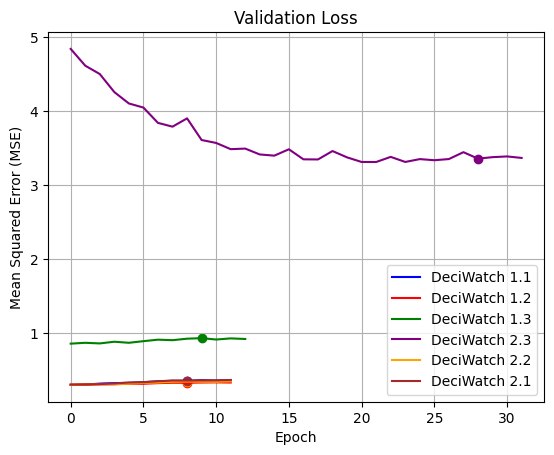

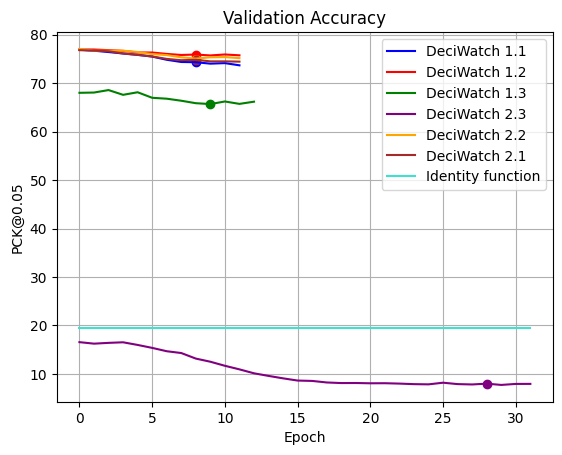

In [13]:
# Baseline plots

model_type = "adapted"
identity_1 = 19.4

plt.figure()
for color, name in zip(colors, adapted_names):
    path = model_paths[name]
    config = model_configs[name]
    learning_rate = learning_rates[name]
    label = get_label(model_type, config)

    train_losses = np.load(path + "train_losses.npy")
    xs = np.arange(1, len(train_losses) + 1)
    plt.plot(xs, train_losses, c=color, label=label)
    
    for epoch in learning_rate.keys():
        plt.scatter(epoch, train_losses[epoch - 1], c=color)
    
plt.grid()
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.savefig(f"./{model_type}/train_losses.png")

plt.figure()
for color, name in zip(colors, adapted_names):
    path = model_paths[name]
    config = model_configs[name]
    learning_rate = learning_rates[name]
    label = get_label(model_type, config)

    val_losses = np.load(path + "val_losses.npy")
    xs = np.arange(len(val_losses))
    plt.plot(xs, val_losses, c=color, label=label)
    
    for epoch in learning_rate.keys():
        plt.scatter(epoch, val_losses[epoch], c=color)
    
plt.grid()
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.savefig(f"./{model_type}/val_losses.png")

plt.figure()
max_len = 0
for color, name in zip(colors, adapted_names):
    path = model_paths[name]
    config = model_configs[name]
    learning_rate = learning_rates[name]
    label = get_label(model_type, config)

    val_accs = np.load(path + "val_accs.npy") * 100
    num_epochs = len(val_accs)
    max_len = max(max_len, num_epochs)
    xs = np.arange(num_epochs)
    plt.plot(xs, val_accs, c=color, label=label)
    
    for epoch in learning_rate.keys():
        plt.scatter(epoch, val_accs[epoch], c=color)
    
plt.plot(np.arange(max_len), np.full(max_len, identity_1), c="turquoise", label="Identity function")

plt.grid()
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("PCK@0.05")
plt.legend(loc="upper right")
plt.savefig(f"./{model_type}/val_accs.png")

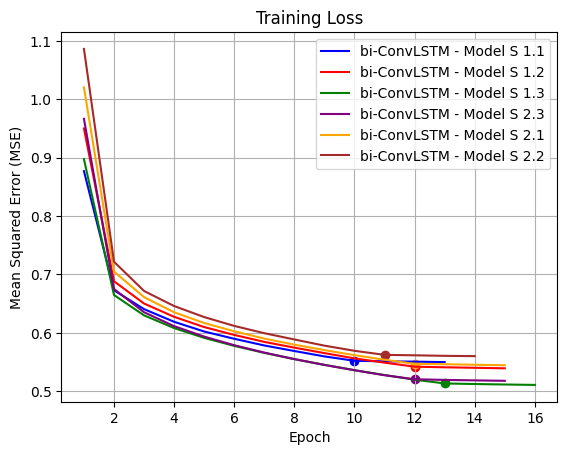

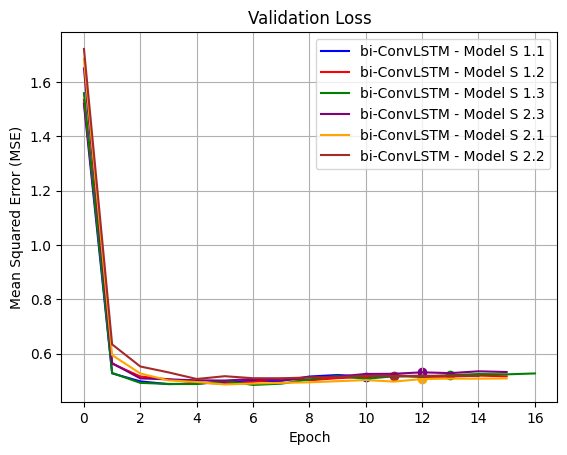

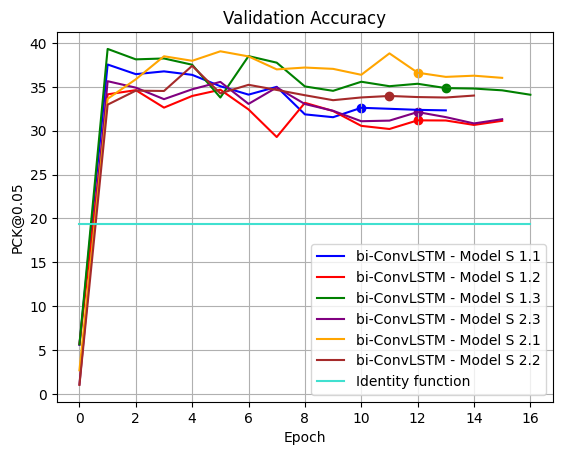

In [10]:
# Baseline plots

model_type = "unipose"
identity_1 = 19.4

plt.figure()
for color, name in zip(colors, unipose_names):
    path = model_paths[name]
    config = model_configs[name]
    learning_rate = learning_rates[name]
    label = get_label(model_type, config)

    train_losses = np.load(path + "train_losses.npy")
    xs = np.arange(1, len(train_losses) + 1)
    plt.plot(xs, train_losses, c=color, label=label)
    
    for epoch in learning_rate.keys():
        plt.scatter(epoch, train_losses[epoch - 1], c=color)
    
plt.grid()
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.savefig(f"./{model_type}/train_losses.png")

plt.figure()
for color, name in zip(colors, unipose_names):
    path = model_paths[name]
    config = model_configs[name]
    learning_rate = learning_rates[name]
    label = get_label(model_type, config)

    val_losses = np.load(path + "val_losses.npy")
    xs = np.arange(len(val_losses))
    plt.plot(xs, val_losses, c=color, label=label)
    
    for epoch in learning_rate.keys():
        plt.scatter(epoch, val_losses[epoch], c=color)
    
plt.grid()
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.savefig(f"./{model_type}/val_losses.png")

plt.figure()
max_len = 0
for color, name in zip(colors, unipose_names):
    path = model_paths[name]
    config = model_configs[name]
    learning_rate = learning_rates[name]
    label = get_label(model_type, config)

    val_accs = np.load(path + "val_accs.npy") * 100
    num_epochs = len(val_accs)
    max_len = max(max_len, num_epochs)
    xs = np.arange(num_epochs)
    plt.plot(xs, val_accs, c=color, label=label)
    
    for epoch in learning_rate.keys():
        plt.scatter(epoch, val_accs[epoch], c=color)
    
plt.plot(np.arange(max_len), np.full(max_len, identity_1), c="turquoise", label="Identity function")

plt.grid()
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("PCK@0.05")
plt.legend()
plt.savefig(f"./{model_type}/val_accs.png")

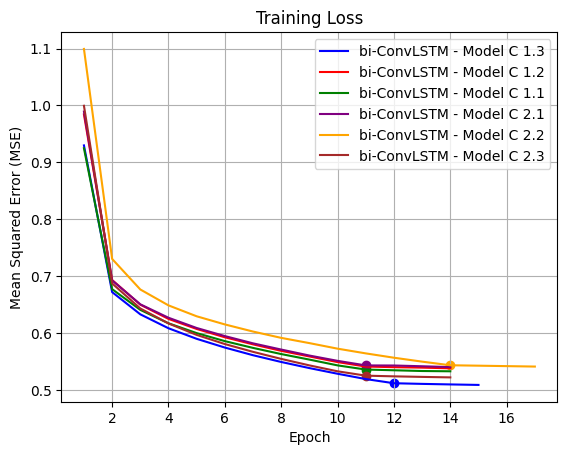

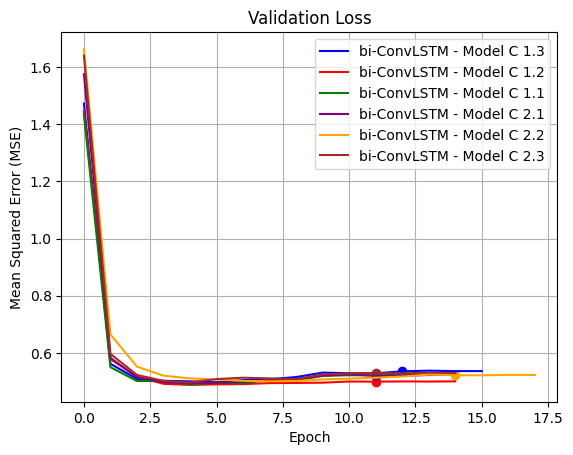

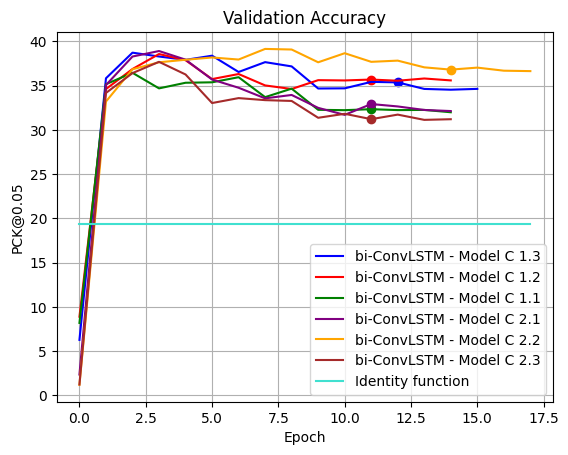

In [11]:
# Baseline plots

model_type = "unipose2"
identity_1 = 19.4

plt.figure()
for color, name in zip(colors, unipose2_names):
    path = model_paths[name]
    config = model_configs[name]
    learning_rate = learning_rates[name]
    label = get_label(model_type, config)

    train_losses = np.load(path + "train_losses.npy")
    xs = np.arange(1, len(train_losses) + 1)
    plt.plot(xs, train_losses, c=color, label=label)
    
    for epoch in learning_rate.keys():
        plt.scatter(epoch, train_losses[epoch - 1], c=color)
    
plt.grid()
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.savefig(f"./{model_type}/train_losses.png")

plt.figure()
for color, name in zip(colors, unipose2_names):
    path = model_paths[name]
    config = model_configs[name]
    learning_rate = learning_rates[name]
    label = get_label(model_type, config)

    val_losses = np.load(path + "val_losses.npy")
    xs = np.arange(len(val_losses))
    plt.plot(xs, val_losses, c=color, label=label)
    
    for epoch in learning_rate.keys():
        plt.scatter(epoch, val_losses[epoch], c=color)
    
plt.grid()
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.savefig(f"./{model_type}/val_losses.png")

plt.figure()
max_len = 0
for color, name in zip(colors, unipose2_names):
    path = model_paths[name]
    config = model_configs[name]
    learning_rate = learning_rates[name]
    label = get_label(model_type, config)

    val_accs = np.load(path + "val_accs.npy") * 100
    num_epochs = len(val_accs)
    max_len = max(max_len, num_epochs)
    xs = np.arange(num_epochs)
    plt.plot(xs, val_accs, c=color, label=label)
    
    for epoch in learning_rate.keys():
        plt.scatter(epoch, val_accs[epoch], c=color)
    
plt.plot(np.arange(max_len), np.full(max_len, identity_1), c="turquoise", label="Identity function")

plt.grid()
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("PCK@0.05")
plt.legend()
plt.savefig(f"./{model_type}/val_accs.png")